# MDG1 - Eradicate Extreme Poverty And Hunger 

#### In order to begin our analysis let's review how wealth has grown around the years among the different countries. 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

In [15]:
country_metadata = pd.read_csv('data\\GDP_BY_COUNTRY\\Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv')
country_metadata.drop(['IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5'], axis=1, inplace=True)

# Loading historical GDP by country data from World Bank Data(data.worldbank.org)
historical_gdp_by_country = pd.read_csv('data\\GDP_BY_COUNTRY\\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv', header=2)
historical_gdp_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_gdp_by_country = pd.merge(historical_gdp_by_country, country_metadata, how='left', on=['Country Code'])
historical_gdp_by_country = historical_gdp_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='GDP(US$)')

historical_gdp_by_country['GDP(US$)'] = historical_gdp_by_country['GDP(US$)'].apply(lambda x : x/10**9)
historical_gdp_by_country.rename(columns={'GDP(US$)': 'GDP(US$ in Billions)'}, inplace=True)

# Loading historical Population by country data from World Bank(data.worldbank.org)
historical_pop_by_country = pd.read_csv('data\\POP_BY_COUNTRY\\API_SP.POP.TOTL_DS2_en_csv_v2_10515200.csv', header=2)
historical_pop_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_pop_by_country = pd.merge(historical_pop_by_country, country_metadata, how='left', on=['Country Code'])
historical_pop_by_country = historical_pop_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='Pop(in millions)')

historical_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Pop(in millions)'] != 'SP.POP.TOTL') & (historical_pop_by_country['Pop(in millions)'] != 'Population, total')]
historical_pop_by_country['Pop(in millions)'].astype(np.float64, copy=False)
historical_pop_by_country['Pop(in millions)'] = historical_pop_by_country['Pop(in millions)'].apply(lambda x : x/10**6)

In [16]:
historical_gdp_by_region = historical_gdp_by_country.groupby(by=['Region','Year'], as_index=False).agg({'GDP(US$ in Billions)': 'sum'})
historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['GDP(US$ in Billions)'] > 0]

historical_pop_by_region = historical_pop_by_country.groupby(by=['Region', 'Year'], as_index=False).agg({'Pop(in millions)': 'sum'})
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Pop(in millions)'] > 0]

historical_gdp_per_capita_by_region = historical_gdp_by_region[['Region', 'Year']]
historical_gdp_per_capita_by_region['GDP Per Capita (per US$1.000,00)'] = historical_gdp_by_region['GDP(US$ in Billions)']*(10**3)/historical_pop_by_region['Pop(in millions)']

historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['Year'] > '1980']
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Year'] > '1980']
historical_gdp_per_capita_by_region = historical_gdp_per_capita_by_region[historical_gdp_per_capita_by_region['Year'] > '1980']


## Brief Economical Evaluation - GDP, Population and GDP per capita

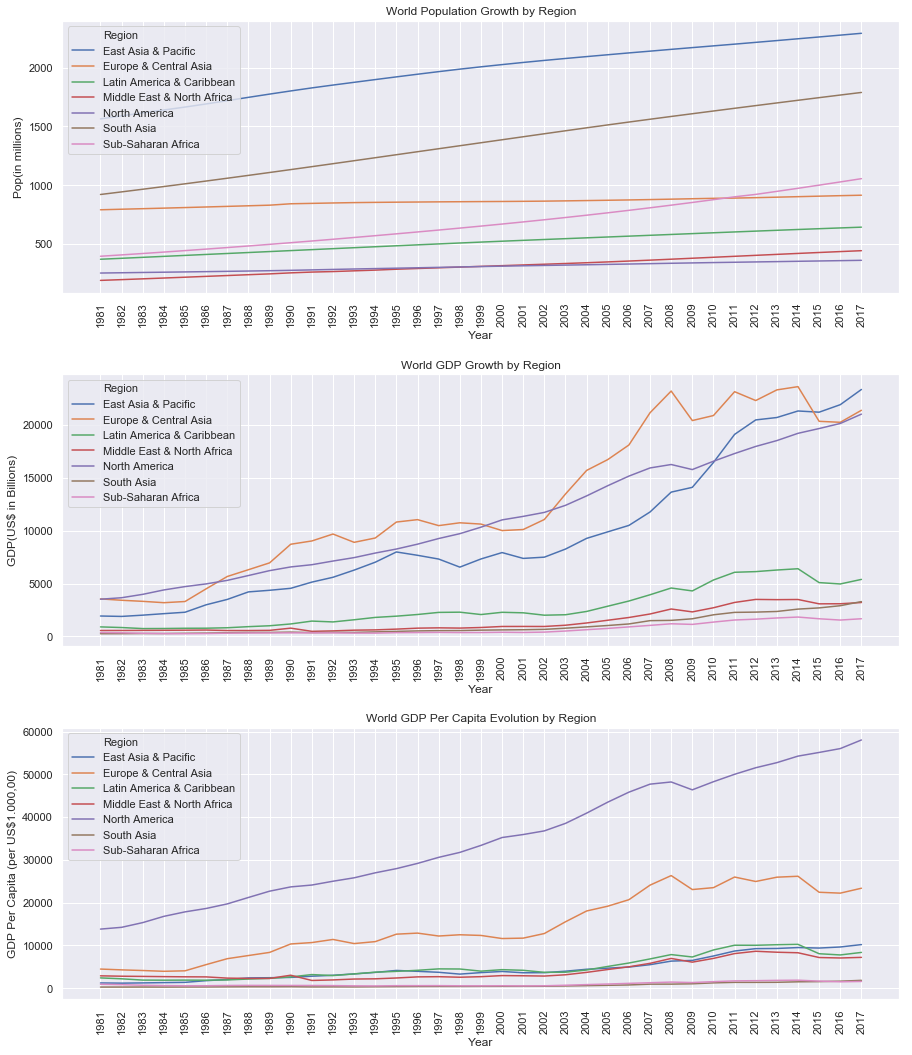

In [17]:
fig,ax = plt.subplots(nrows=3, figsize=(15,18))
titles = ['World Population Growth by Region', 'World GDP Growth by Region', 'World GDP Per Capita Evolution by Region']
for i in range(3):
    plt.sca(ax[i])
    plt.title(titles[i])
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)

sns.lineplot(x='Year', y='Pop(in millions)', hue='Region', data=historical_pop_by_region, ax=ax[0])
sns.lineplot(x='Year', y='GDP(US$ in Billions)', hue='Region', data=historical_gdp_by_region, ax=ax[1])
sns.lineplot(x='Year', y='GDP Per Capita (per US$1.000,00)', hue='Region', data=historical_gdp_per_capita_by_region, ax=ax[2])

## Analyzing Extreme Poverty Distribution around the Globe

In [18]:
def createWBDataFrame(path):
    df = pd.read_csv(path, header=2)
    df = pd.merge(df, country_metadata, how='left', on=['Country Code'])
    return df.drop(['Indicator Name', 'Unnamed: 63'], axis=1)

def tideWBDataFrame(df):
    df = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Region', 'Indicator Code'], var_name='Year', value_name='observation')
    df = pd.pivot_table(df, columns=['Indicator Code'], index=['Country Name', 'Country Code', 'Region', 'Year'], values='observation', aggfunc=np.mean)
    return df.reset_index()

def keepMetrics(df, metrics):
    standard_columns = ['Country Name', 'Country Code', 'Region', 'Year']
    return df.loc[:, standard_columns + metrics]

In [19]:
extreme_poverty_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
extreme_poverty_by_country = tideWBDataFrame(extreme_poverty_by_country)

# Limiting data for the last 30 years
extreme_poverty_by_country = extreme_poverty_by_country[extreme_poverty_by_country['Year'] > '1980']
extreme_poverty_by_country = keepMetrics(extreme_poverty_by_country, ['SI.POV.DDAY','SP.POP.TOTL'])

# Renaming observation columns
extreme_poverty_by_country.rename(columns={'SI.POV.DDAY': 'Extreme Poverty(% pop)','SP.POP.TOTL': 'Total Pop.'}, inplace=True)

### 1.0 - Extreme Poverty Distribution

In [20]:
# Manipulating data to bring a better understanding of the situation.
extreme_poverty_by_country['last_obs_year'] = np.nan
extreme_poverty_by_country['last_obs_year'] = extreme_poverty_by_country[extreme_poverty_by_country['Extreme Poverty(% pop)'].notnull()]['Year']
extreme_poverty_by_country.sort_values(['Country Code', 'Year'], inplace=True)

aux = pd.DataFrame(columns=extreme_poverty_by_country.columns)
for code in extreme_poverty_by_country['Country Code'].unique():
    aux = pd.concat([aux, extreme_poverty_by_country[extreme_poverty_by_country['Country Code'] == code].fillna(method='ffill')])
extreme_poverty_by_country = aux

extreme_poverty_by_country['Total Pop. in Extreme Poverty'] = extreme_poverty_by_country['Total Pop.']*extreme_poverty_by_country['Extreme Poverty(% pop)']/100
extreme_poverty_by_country['text'] = ["{one}<br>Extreme Poverty: {two} % <br>Extreme Poverty: {three} millions<br>Last obtained: {four}".format(one=row['Country Name'], two=row['Extreme Poverty(% pop)'], three=np.round(row['Total Pop. in Extreme Poverty']/10**6, 3), four=row['last_obs_year']) for index, row in extreme_poverty_by_country.iterrows()]     

### First Visualization

In [21]:
data_slider = []
for year in extreme_poverty_by_country['Year'].unique():
    extreme_poverty_year = extreme_poverty_by_country[extreme_poverty_by_country['Year'] == year]
    
    data = go.Choropleth(
                locationmode='ISO-3',
                locations=extreme_poverty_year['Country Code'],
                text=extreme_poverty_year['text'],
                z=extreme_poverty_year['Extreme Poverty(% pop)'],
                colorbar={'title':'Extreme Poverty (% of Population)','ticksuffix': '%'} 
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of Extreme Poverty (From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                steps = steps,
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1}
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

### Second Visualization

In [30]:
extreme_poverty_by_region = extreme_poverty_by_country.loc[:, ['Region', 'Year', 'Total Pop. in Extreme Poverty', 'Total Pop.']]
extreme_poverty_by_region.dropna(inplace=True)

extreme_poverty_by_region = extreme_poverty_by_region.groupby(['Region', 'Year'], as_index=False).agg({'Total Pop. in Extreme Poverty': 'sum', 'Total Pop.': 'sum'})
extreme_poverty_by_region['Mean Pop. in Extreme Poverty'] = np.round(100*extreme_poverty_by_region['Total Pop. in Extreme Poverty']/extreme_poverty_by_region['Total Pop.'], 2)

extreme_poverty_by_region = extreme_poverty_by_region[extreme_poverty_by_region['Year'] >= '1990']
extreme_poverty_by_region.sort_values(by=['Year', 'Region'], inplace=True)

In [42]:
layout = go.Layout( 
    xaxis = go.layout.XAxis(
        tickmode='array',
        tickvals=np.arange(1990, 2018, step=1),
        hover
        title='Years'
    )
)

fig = go.Figure(
    layout=layout
)
        
for region in extreme_poverty_by_region['Region'].unique():
    ext_pov_region = extreme_poverty_by_region[extreme_poverty_by_region['Region'] == region]
    fig.add_scatter(x=ext_pov_region['Year'], y=ext_pov_region['Mean Pop. in Extreme Poverty'], name=region, mode='lines')
    
iplot(fig)

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.XAxis: 'hoverinfo'

    Valid properties:
        anchor
            If set to an opposite-letter axis id (e.g. `x2`, `y`),
            this axis is bound to the corresponding opposite-letter
            axis. If set to "free", this axis' position is
            determined by `position`.
        automargin
            Determines whether long tick labels automatically grow
            the figure margins.
        autorange
            Determines whether or not the range of this axis is
            computed in relation to the input data. See `rangemode`
            for more info. If `range` is provided, then `autorange`
            is set to False.
        calendar
            Sets the calendar system to use for `range` and `tick0`
            if this is a date axis. This does not set the calendar
            for interpreting data on this axis, that's specified in
            the trace or via the global `layout.calendar`
        categoryarray
            Sets the order in which categories on this axis appear.
            Only has an effect if `categoryorder` is set to
            "array". Used with `categoryorder`.
        categoryarraysrc
            Sets the source reference on plot.ly for  categoryarray
            .
        categoryorder
            Specifies the ordering logic for the case of
            categorical variables. By default, plotly uses "trace",
            which specifies the order that is present in the data
            supplied. Set `categoryorder` to *category ascending*
            or *category descending* if order should be determined
            by the alphanumerical order of the category names. Set
            `categoryorder` to "array" to derive the ordering from
            the attribute `categoryarray`. If a category is not
            found in the `categoryarray` array, the sorting
            behavior for that attribute will be identical to the
            "trace" mode. The unspecified categories will follow
            the categories in `categoryarray`.
        color
            Sets default for all colors associated with this axis
            all at once: line, font, tick, and grid colors. Grid
            color is lightened by blending this with the plot
            background Individual pieces can override this.
        constrain
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines how that happens: by increasing
            the "range" (default), or by decreasing the "domain".
        constraintoward
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines which direction we push the
            originally specified plot area. Options are "left",
            "center" (default), and "right" for x axes, and "top",
            "middle" (default), and "bottom" for y axes.
        dividercolor
            Sets the color of the dividers Only has an effect on
            "multicategory" axes.
        dividerwidth
            Sets the width (in px) of the dividers Only has an
            effect on "multicategory" axes.
        domain
            Sets the domain of this axis (in plot fraction).
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        fixedrange
            Determines whether or not this axis is zoom-able. If
            true, then zoom is disabled.
        gridcolor
            Sets the color of the grid lines.
        gridwidth
            Sets the width (in px) of the grid lines.
        hoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see: https://github.com/d3/d3-form
            at/blob/master/README.md#locale_format And for dates
            see: https://github.com/d3/d3-time-
            format/blob/master/README.md#locale_format We add one
            item to d3's date formatter: "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        layer
            Sets the layer on which this axis is displayed. If
            *above traces*, this axis is displayed above all the
            subplot's traces If *below traces*, this axis is
            displayed below all the subplot's traces, but above the
            grid lines. Useful when used together with scatter-like
            traces with `cliponaxis` set to False to show markers
            and/or text nodes above this axis.
        linecolor
            Sets the axis line color.
        linewidth
            Sets the width (in px) of the axis line.
        matches
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis will match the range of the corresponding
            axis in data-coordinates space. Moreover, matching axes
            share auto-range values, category lists and histogram
            auto-bins. Note that setting axes simultaneously in
            both a `scaleanchor` and a `matches` constraint is
            currently forbidden. Moreover, note that matching axes
            must have the same `type`.
        mirror
            Determines if the axis lines or/and ticks are mirrored
            to the opposite side of the plotting area. If True, the
            axis lines are mirrored. If "ticks", the axis lines and
            ticks are mirrored. If False, mirroring is disable. If
            "all", axis lines are mirrored on all shared-axes
            subplots. If "allticks", axis lines and ticks are
            mirrored on all shared-axes subplots.
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        overlaying
            If set a same-letter axis id, this axis is overlaid on
            top of the corresponding same-letter axis, with traces
            and axes visible for both axes. If False, this axis
            does not overlay any same-letter axes. In this case,
            for axes with overlapping domains only the highest-
            numbered axis will be visible.
        position
            Sets the position of this axis in the plotting space
            (in normalized coordinates). Only has an effect if
            `anchor` is set to "free".
        range
            Sets the range of this axis. If the axis `type` is
            "log", then you must take the log of your desired range
            (e.g. to set the range from 1 to 100, set the range
            from 0 to 2). If the axis `type` is "date", it should
            be date strings, like date data, though Date objects
            and unix milliseconds will be accepted and converted to
            strings. If the axis `type` is "category", it should be
            numbers, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        rangemode
            If "normal", the range is computed in relation to the
            extrema of the input data. If *tozero*`, the range
            extends to 0, regardless of the input data If
            "nonnegative", the range is non-negative, regardless of
            the input data. Applies only to linear axes.
        rangeselector
            plotly.graph_objs.layout.xaxis.Rangeselector instance
            or dict with compatible properties
        rangeslider
            plotly.graph_objs.layout.xaxis.Rangeslider instance or
            dict with compatible properties
        scaleanchor
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis changes together with the range of the
            corresponding axis such that the scale of pixels per
            unit is in a constant ratio. Both axes are still
            zoomable, but when you zoom one, the other will zoom
            the same amount, keeping a fixed midpoint. `constrain`
            and `constraintoward` determine how we enforce the
            constraint. You can chain these, ie `yaxis:
            {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}` but you
            can only link axes of the same `type`. The linked axis
            can have the opposite letter (to constrain the aspect
            ratio) or the same letter (to match scales across
            subplots). Loops (`yaxis: {scaleanchor: *x*}, xaxis:
            {scaleanchor: *y*}` or longer) are redundant and the
            last constraint encountered will be ignored to avoid
            possible inconsistent constraints via `scaleratio`.
            Note that setting axes simultaneously in both a
            `scaleanchor` and a `matches` constraint is currently
            forbidden.
        scaleratio
            If this axis is linked to another by `scaleanchor`,
            this determines the pixel to unit scale ratio. For
            example, if this value is 10, then every unit on this
            axis spans 10 times the number of pixels as a unit on
            the linked axis. Use this for example to create an
            elevation profile where the vertical scale is
            exaggerated a fixed amount with respect to the
            horizontal.
        separatethousands
            If "true", even 4-digit integers are separated
        showdividers
            Determines whether or not a dividers are drawn between
            the category levels of this axis. Only has an effect on
            "multicategory" axes.
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showgrid
            Determines whether or not grid lines are drawn. If
            True, the grid lines are drawn at every tick mark.
        showline
            Determines whether or not a line bounding this axis is
            drawn.
        showspikes
            Determines whether or not spikes (aka droplines) are
            drawn for this axis. Note: This only takes affect when
            hovermode = closest
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        side
            Determines whether a x (y) axis is positioned at the
            "bottom" ("left") or "top" ("right") of the plotting
            area.
        spikecolor
            Sets the spike color. If undefined, will use the series
            color
        spikedash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        spikemode
            Determines the drawing mode for the spike line If
            "toaxis", the line is drawn from the data point to the
            axis the  series is plotted on. If "across", the line
            is drawn across the entire plot area, and supercedes
            "toaxis". If "marker", then a marker dot is drawn on
            the axis the series is plotted on
        spikesnap
            Determines whether spikelines are stuck to the cursor
            or to the closest datapoints.
        spikethickness
            Sets the width (in px) of the zero line.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the tick font.
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see: https://github.com/d3/d3-form
            at/blob/master/README.md#locale_format And for dates
            see: https://github.com/d3/d3-time-
            format/blob/master/README.md#locale_format We add one
            item to d3's date formatter: "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            plotly.graph_objs.layout.xaxis.Tickformatstop instance
            or dict with compatible properties
        tickformatstopdefaults
            When used in a template (as
            layout.template.layout.xaxis.tickformatstopdefaults),
            sets the default property values to use for elements of
            layout.xaxis.tickformatstops
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        tickson
            Determines where ticks and grid lines are drawn with
            respect to their corresponding tick labels. Only has an
            effect for axes of `type` "category" or
            "multicategory". When set to "boundaries", ticks and
            grid lines are drawn half a category to the left/bottom
            of labels.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on plot.ly for  ticktext .
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on plot.ly for  tickvals .
        tickwidth
            Sets the tick width (in px).
        title
            plotly.graph_objs.layout.xaxis.Title instance or dict
            with compatible properties
        titlefont
            Deprecated: Please use layout.xaxis.title.font instead.
            Sets this axis' title font. Note that the title's font
            used to be customized by the now deprecated `titlefont`
            attribute.
        type
            Sets the axis type. By default, plotly attempts to
            determined the axis type by looking into the data of
            the traces that referenced the axis in question.
        uirevision
            Controls persistence of user-driven changes in axis
            `range`, `autorange`, and `title` if in `editable:
            true` configuration. Defaults to `layout.uirevision`.
        visible
            A single toggle to hide the axis while preserving
            interaction like dragging. Default is true when a
            cheater plot is present on the axis, otherwise false
        zeroline
            Determines whether or not a line is drawn at along the
            0 value of this axis. If True, the zero line is drawn
            on top of the grid lines.
        zerolinecolor
            Sets the line color of the zero line.
        zerolinewidth
            Sets the width (in px) of the zero line.
        

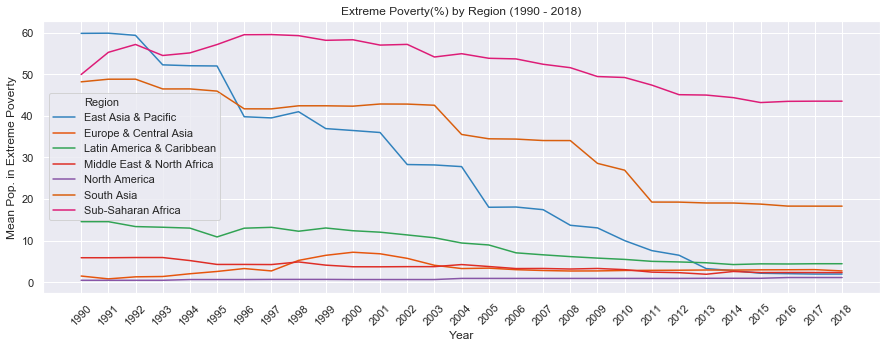

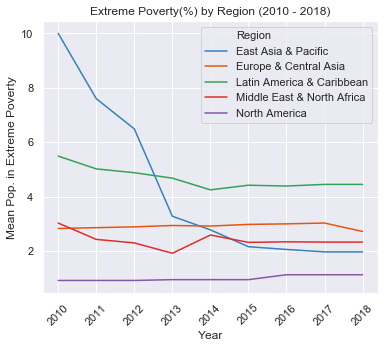

In [11]:
pal_1 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7', '#d95f0e', '#dd1c77']
pal_2 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7']
# Line chart grouping extreme poverty data by region

# This chart only takes into account the countries that have provided at least one data regarding Extreme Poverty in the timeframe presented(1981-2017).
# The data for Extreme Poverty considered by the chart is the last data provided by the country.
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (1990 - 2018)')
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region, palette=pal_1)

# Show another line chart to focus on the last years for East Asia, Latin America, North America, Middle East and Europe
plt.figure(figsize=(6, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (2010 - 2018)')
extreme_poverty_by_region_sub = extreme_poverty_by_region[(~extreme_poverty_by_region['Region'].isin(['South Asia', 'Sub-Saharan Africa'])) & (extreme_poverty_by_region['Year']>='2010')]
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region_sub, palette=pal_2)

## Analyzing Deeper Socioeconomical, Healthy and Environmental Factors

#### Sub-Saharan Africa and South Asia are clearly the regions that need most assistance when it comes to eradicating poverty. 
#### Hence they along with Latin America will be the ones we look deeper to understand the driving factors that inhibit development on these countries.
#### In this section, we look at environmental, health, social and economical factors that might keep a nation from thriving economically. 

In [12]:
health_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Health\\API_8_DS2_en_csv_v2_10576655.csv')
health_by_country = tideWBDataFrame(health_by_country)
health_by_country = keepMetrics(health_by_country, ['SH.DYN.MORT', 'SH.DYN.AIDS.ZS', 'SH.TBS.INCD', 'SH.DTH.COMM.ZS', 'SN.ITK.DEFC.ZS', 'SP.DYN.TFRT.IN', 'SH.XPD.CHEX.GD.ZS'])
health_by_country.rename(columns={'SH.DYN.MORT': 'Mortality Rate Under 5(per 1.000 births)', 'SH.DYN.AIDS.ZS':'HIV - 15 to 49 (%)', 'SH.TBS.INCD': 'Inc. Tuberculosis(per 100.000)', 'SH.DTH.COMM.ZS': 'Death by Infectious Disease(5 of total)', 'SN.ITK.DEFC.ZS':'Undernourishment(% pop)', 'SP.DYN.TFRT.IN': 'Total Births per Women', 'SH.XPD.CHEX.GD.ZS': 'Expenditure on Health(% of GDP)'}, inplace=True)
health_by_country = health_by_country[health_by_country['Year'] > '1999']

underage_labour_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Labour\\API_10_DS2_en_csv_v2_10597117.csv')
underage_labour_by_country = tideWBDataFrame(underage_labour_by_country)
underage_labour_by_country = keepMetrics(underage_labour_by_country, ['SL.TLF.0714.ZS', 'SL.TLF.0714.WK.ZS', 'SL.TLF.0714.WK.TM', 'SL.UEM.NEET.ZS'])
underage_labour_by_country.rename(columns={'SL.TLF.0714.ZS': 'Children in employment 7-14 (% of children)', 'SL.TLF.0714.WK.ZS': 'Children in employment(Work only) - 7 to 14(% of chd in emp.)', 'SL.TLF.0714.WK.TM': 'Avg. Working Hours of work only children', 'SL.UEM.NEET.ZS': 'Not studying, not working (% of youth)'}, inplace=True)
underage_labour_by_country = underage_labour_by_country[underage_labour_by_country['Year'] > '1999']

education_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Education\\API_4_DS2_en_csv_v2_10577018.csv')
education_by_country = tideWBDataFrame(education_by_country)
education_by_country = keepMetrics(education_by_country, ['SE.PRM.CMPT.ZS', 'SE.PRM.UNER.ZS', 'SE.PRM.ENRL.TC.ZS', 'SE.ADT.1524.LT.ZS', 'SE.XPD.TOTL.GD.ZS'])
education_by_country.rename(columns={'SE.PRM.CMPT.ZS': 'Primary Completion Rate (% of relevant age group)', 'SE.PRM.UNER.ZS': 'Children out of School(% primary school)',  'SE.PRM.ENRL.TC.ZS': 'Pupil Teacher ratio', 'SE.ADT.1524.LT.ZS': 'Youth Literacy Rate 15-24 (% pop)', 'SE.XPD.TOTL.GD.ZS': 'Expenditure on Education (% of GDP)'}, inplace=True)
education_by_country = education_by_country[education_by_country['Year'] > '1999']

economics_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Economics\\API_3_DS2_en_csv_v2_10577958.csv')
economics_by_country = tideWBDataFrame(economics_by_country)
economics_by_country = keepMetrics(economics_by_country, ['NY.GDP.PCAP.CD', 'NY.GDP.MKTP.KD.ZG', 'FP.CPI.TOTL.ZG', 'DT.ODA.ODAT.PC.ZS'])
economics_by_country.rename(columns={'NY.GDP.PCAP.CD': 'GDP per Capita(US$)', 'NY.GDP.MKTP.KD.ZG': 'GDP Growth(%)', 'FP.CPI.TOTL.ZG': 'Inflation Rate(%)', 'DT.ODA.ODAT.PC.ZS': 'ODA per capita(US$)'}, inplace=True)
economics_by_country = economics_by_country[economics_by_country['Year'] > '1999']
economics_by_country['text'] = ["{one}<br>GDP Growth: {two}% <br>GDP per capita: US${three} <br>Inflation Rate: {four}% <br>ODA per capita: US${five}".format(one=row['Country Name'], two=np.round(row['GDP Growth(%)'],2), three=np.round(row['GDP per Capita(US$)'],2), four=np.round(row['Inflation Rate(%)'],2), five=np.round(row['ODA per capita(US$)'],2)) for index, row in economics_by_country.iterrows()] 

environment_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
environment_by_country = tideWBDataFrame(environment_by_country)
environment_by_country = keepMetrics(environment_by_country, ['AG.LND.PRCP.MM','EN.CLC.MDAT.ZS','AG.LND.ARBL.ZS','AG.LND.IRIG.AG.ZS','NV.AGR.TOTL.ZS','AG.YLD.CREL.KG', 'EG.ELC.ACCS.ZS'])
environment_by_country.rename(columns={'AG.LND.PRCP.MM': 'Avg precipitation(mm)','EN.CLC.MDAT.ZS': '% Pop affected by extreme conditions(Droughts, Flood, high temps)','AG.LND.ARBL.ZS': '% Arable Land','AG.LND.IRIG.AG.ZS': '% Agric. Irrigated Land','NV.AGR.TOTL.ZS': 'Agric., Florestry and Fishing(% of GDP)','AG.YLD.CREL.KG': 'Cereal Yield(Kg/hectare)','EG.ELC.ACCS.ZS': 'Access Electricity(% pop)'}, inplace=True)
environment_by_country = environment_by_country[environment_by_country['Year'] > '1999']

### 1.3 - Principal Problems faced by different regions

#### Sub-Saharan Africa (Last 17 years)

##### How is the expenditure of Africa's GDP distributed? How much goes to Education? How much goes to Medical Care?

##### How dependent is Africa of their agricultural production? What % of the GDP does it represent?

##### Which countries have lower literacy rate and higher disease problems? What about children education? Are they at school or working?

##### How is the ODA distributed among the countries? Are the countries with highest ODA per capita the ones that need most assistance?

##### Are the fundamental living assets available to most people: electricity, fresh water, internet, etc? 

In [121]:
economics_by_country_africa = economics_by_country[economics_by_country['Region'] == 'Sub-Saharan Africa']
underage_labour_by_country_africa = underage_labour_by_country[underage_labour_by_country['Region'] == 'Sub-Saharan Africa']
education_by_country_africa = education_by_country[education_by_country['Region'] == 'Sub-Saharan Africa']
environment_by_country_africa = environment_by_country[environment_by_country['Region'] == 'Sub-Saharan Africa']
health_by_country_africa = health_by_country[health_by_country['Region'] == 'Sub-Saharan Africa']

In [156]:
g_ed = education_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Education (% of GDP)']]
g_health = health_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Health(% of GDP)']]

g_ed_and_health = pd.merge(g_ed, g_health, on=['Year', 'Region', 'Country Code', 'Country Name'])
g_ed_health_econ
g_ed_and_health = g_ed_and_health.groupby(['Year', 'Region'], as_index=False).agg({'Expenditure on Education (% of GDP)':'mean', 'Expenditure on Health(% of GDP)': 'mean'})


In [158]:
g_ed_and_health['Region'].unique()

array(['East Asia & Pacific', 'Europe & Central Asia',
       'Latin America & Caribbean', 'Middle East & North Africa',
       'North America', 'South Asia', 'Sub-Saharan Africa'], dtype=object)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

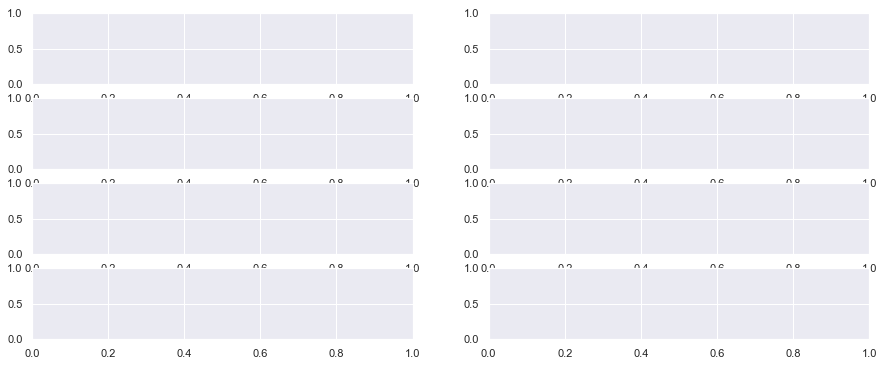

In [161]:
regions = g_ed_and_health['Region'].unique()

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(15,6))
for i in range(7):
    g_ed_and_health_cont = g_ed_and_health[g_ed_and_health['Region'] == regions[i]]
    title = 'Education and Health Expenditures {one}'.format(one=regions[i])
    plt.sca(ax[i])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)
    plt.xlabel('Years')
    plt.ylabel('Expenditure(% of GDP)')
    sns.lineplot(x='Year', y='Expenditure on Education (% of GDP)', hue='Region', data=g_ed_and_health_cont, palette=['red'], ax=ax[i])
    sns.lineplot(x='Year', y='Expenditure on Health(% of GDP)', hue='Region', data=g_ed_and_health_cont, palette=['blue'], ax=ax[i])

In [129]:
health_by_country_africa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1777 entries, 312 to 12552
Data columns (total 11 columns):
Country Name                                1777 non-null object
Country Code                                1777 non-null object
Region                                      1777 non-null object
Year                                        1777 non-null object
Mortality Rate Under 5(per 1.000 births)    1769 non-null float64
HIV - 15 to 49 (%)                          1260 non-null float64
Inc. Tuberculosis(per 100.000)              853 non-null float64
Death by Infectious Disease(5 of total)     192 non-null float64
Undernourishment(% pop)                     668 non-null float64
Total Births per Women                      1763 non-null float64
Expenditure on Health(% of GDP)             772 non-null float64
dtypes: float64(7), object(4)
memory usage: 166.6+ KB


In [106]:
data_slider = []
for year in economics_by_country_africa['Year'].unique():
    economics_by_country_africa_year = economics_by_country_africa[economics_by_country_africa['Year'] == year]
    
    data = go.Choropleth(
            locationmode='ISO-3',
            locations=economics_by_country_africa_year['Country Code'],
            text=economics_by_country_africa_year['text'],
            z=np.round(economics_by_country_africa_year['GDP Growth(%)'],2),
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP Growth(%)', 'ticksuffix': '%'},
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of GDP Growth(From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1},
                steps = steps
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

In [107]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6304 entries, 2 to 7050
Data columns (total 8 columns):
Country Name                                                     6304 non-null object
Country Code                                                     6304 non-null object
Region                                                           6304 non-null object
Year                                                             6304 non-null object
Children in employment 7-14 (% of children)                      281 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    282 non-null float64
Avg. Working Hours of work only children                         126 non-null float64
SL.UEM.NEET.ZS                                                   1230 non-null float64
dtypes: float64(4), object(4)
memory usage: 443.2+ KB


#### South Asia

In [ ]:
economics_by_country_south_asia = economics_by_country[economics_by_country['Region'] == 'South Asia']

In [ ]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=critical_regions_gdp_pop_by_country['Country Code'],
            text=critical_regions_gdp_pop_by_country['Country Name'],
            z=critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'],
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP per capita (in US$1.000,00)'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 South Asia GDP per capita'
            ),
            geo = go.layout.Geo(
                scope='asia',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Latin America and Caribbean

In [125]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7051 entries, 0 to 7050
Data columns (total 8 columns):
Country Name                                                     7051 non-null object
Country Code                                                     7051 non-null object
Region                                                           7051 non-null object
Year                                                             7051 non-null object
Children in employment 7-14 (% of children)                      281 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    282 non-null float64
Avg. Working Hours of work only children                         126 non-null float64
SL.UEM.NEET.ZS                                                   1235 non-null float64
dtypes: float64(4), object(4)
memory usage: 440.8+ KB


In [ ]:
## Find correlation about the metrics

In [48]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=social_metrics_by_country_2016['Country Code'],
            text=social_metrics_by_country_2016['Country Name'],
            z=social_metrics_by_country_2016['Access Electricity(% pop)'],
            colorbar = {'title':'Access to Electricity',
                        'ticksuffix': '%'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2016 - Access to Electricity (% of pop)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)